In [1]:
%load_ext autoreload
%autoreload 2
from expressiveness_benchmark.types import Plan, Task, Language, SourceRange, Program, DATA_DIR
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from interval import interval
from itertools import combinations
from pathlib import Path
from scipy.stats import zscore, rankdata

sns.set(style='whitegrid')

In [37]:
programs = Program.load_all()
tasks = Task.load_all()
languages = Language.load_all()

TASK_BLACKLIST = ['customer_orders', 'unique_product', 'average_adjacent']
programs = programs[~programs.task.isin(TASK_BLACKLIST)]
tasks = tasks[~tasks.id.isin(TASK_BLACKLIST)]

programs = programs[programs.plan != {}] # filter where plan hasn't been labeled
programs = programs[programs.task.isin(tasks.id.tolist())] # filter programs associated to a missing task
programs['category'] = programs.task.map(lambda t: tasks[tasks.id == t].category.iloc[0])

In [38]:
programs['language_name'] = programs['language'].map(lambda id: languages[languages.id == id].iloc[0]['name'])
programs['task_name'] = programs['task'].map(lambda id: tasks[tasks.id == id].iloc[0]['name'])

In [40]:
programs = programs.groupby('task', as_index=False).apply(
    lambda rows: rows.assign(token_zscore=zscore(rows['ntokens']))) \
    .reset_index().drop(['level_0', 'level_1'], axis=1)

In [41]:
p = Path(f'{DATA_DIR}/analysis')
p.mkdir(parents=True, exist_ok=True)
with (p / 'programs.json').open('w') as f:
    f.write(programs.to_json(orient='records'))

In [42]:
LANG_ORDER = [
    languages[languages.id == l].iloc[0]['name']
    for l in ['python-imperative', 'python-functional', 'python-pandas', 'r', 'sql', 'datalog', 'q']
]

# Global analysis

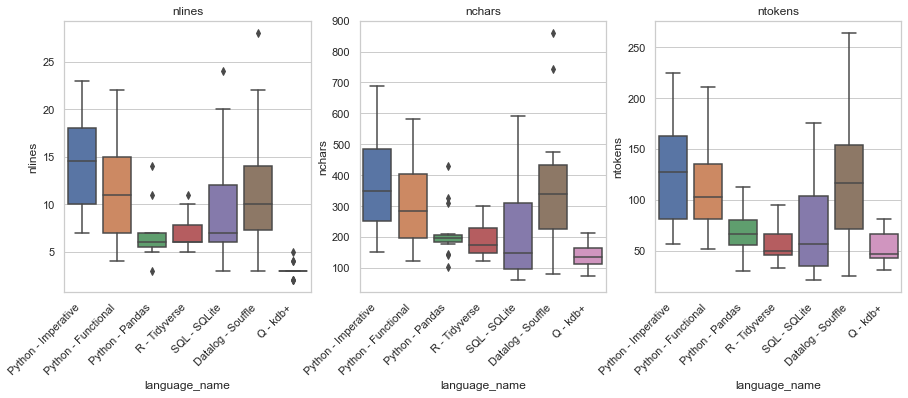

In [17]:
programs['nlines'] = programs.source.map(lambda s: len(s.split('\n')))
programs['nchars'] = programs.source.map(len)

_, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, metric in zip(axes, ['nlines', 'nchars', 'ntokens']):
    ax.set_title(metric)
    sns.boxplot(data=programs, x='language_name', y=metric, order=LANG_ORDER, ax=ax)
    _ = ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')

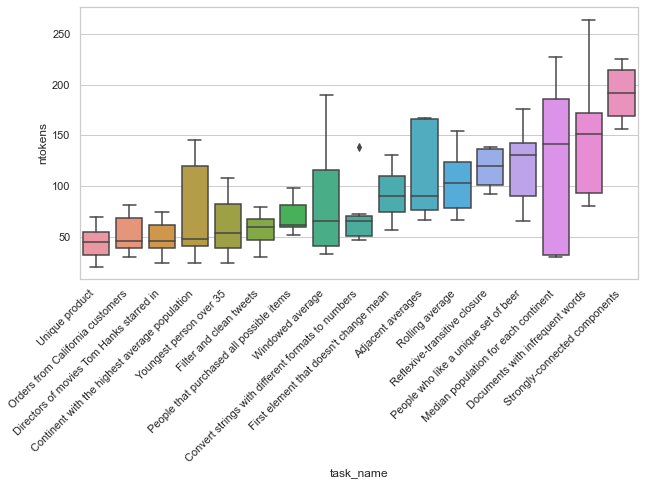

In [18]:
_, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=programs, x='task_name', y='ntokens', 
            order=programs.groupby('task_name').ntokens.median().sort_values().index, 
            ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')

# Grouped analysis

In [19]:
from scipy.stats import zscore, rankdata

def bestworst(inner_group, outer_group, measure='ntokens', score=zscore):
    df = programs.groupby('task', as_index=False).apply(
        lambda rows: rows.assign(
            metric=score(rows[measure]))).reset_index()

    def f(df):
        df = df.groupby(inner_group).metric.mean()
        return pd.DataFrame([{'best': df.index[df.argmin()], 'worst': df.index[df.argmax()]}])

    return df.groupby(outer_group).apply(f).reset_index(level=-1, drop=True)

In [20]:
for group in ['category', 'task']:
    for score in [zscore]: # rankdata
        print(f'GROUP: {group}, SCORE: {score.__name__}')
        print(bestworst(group, 'language', score=score))
        print()

GROUP: category, SCORE: zscore
                                best              worst
language                                               
datalog                        Joins            Strings
python-functional            Strings              Joins
python-imperative            Strings        Time Series
python-pandas            Aggregation              Joins
q                  First-order logic              Joins
r                        Aggregation              Basic
sql                            Basic  First-order logic

GROUP: task, SCORE: zscore
                                          best                 worst
language                                                            
datalog                              tom_hanks    strings_to_numbers
python-functional           strings_to_numbers       customer_orders
python-imperative           strings_to_numbers        average_window
python-pandas      continent_median_population        process_tweets
q                      

In [21]:
for group in ['category', 'task']:
    for score in [zscore]: # rankdata
        print(f'GROUP: {group}, SCORE: {score.__name__}')
        print(bestworst('language', group, score=score))
        print()

GROUP: category, SCORE: zscore
                      best              worst
category                                     
Aggregation              r  python-imperative
Basic                  sql  python-imperative
First-order logic        q  python-imperative
Graphs                 sql  python-imperative
Joins              datalog  python-functional
Strings                  r            datalog
Time Series            sql  python-imperative

GROUP: task, SCORE: zscore
                                          best              worst
task                                                             
average_adjacent                           sql            datalog
average_window                               q  python-imperative
changing_mean                              sql  python-functional
continent_by_population                    sql  python-imperative
continent_median_population      python-pandas            datalog
customer_orders                        datalog  python-functional

# Plan analysis

In [ ]:
def analyze_plan_size(task_id):
    task = tasks[tasks.id == task_id].iloc[0]
    progs = programs[programs.task == task_id]
    goals = pd.DataFrame(task.plan)

    plan_size = progs.apply(
        lambda p: pd.DataFrame([{
            'goal': goals[goals.id == k].iloc[0].description,
            'language': p.language,
            'metric': sum([span['end'] - span['start'] for span in v]),

        } for k,v in p.plan.items()]), 
        axis=1)
    df = pd.concat(plan_size.tolist())
    df = df.groupby('goal', as_index=False) \
        .apply(lambda rows: rows.assign(score=zscore(rows.metric))).reset_index()
    
    print('WORST PLAN BY SIZE')
    print(df.loc[df.groupby('language').score.idxmax()][['language', 'goal']])
    print()
    print('BEST PLAN BY SIZE')
    print(df.loc[df.groupby('language').score.idxmin()][['language', 'goal']])

In [ ]:
analyze_plan_size('strings_to_numbers')

In [ ]:
def coord_to_1d(lines, line, column):
    return sum([len(l) for l in lines[:line]]) + column        
    
def plan_overlap(row):
    lines = row.source.split('\n')
    plan_df = pd.DataFrame([{'key': k, **v} for k, vs in row.plan.items() for v in vs])
    plan_df['byte_start'] = plan_df.apply(lambda row: coord_to_1d(lines, row.line, row.start), axis=1)
    plan_df['byte_end'] = plan_df.apply(lambda row: coord_to_1d(lines, row.line, row.end), axis=1)

    full_intervals = plan_df.groupby('key').apply(
        lambda rows: interval[rows.byte_start.min(), rows.byte_end.max()])
    all_pairs = combinations(full_intervals.tolist(), r=2)
    return sum([1 if l & r else 0 for (l, r) in all_pairs])

programs['plan_overlap'] = programs.apply(plan_overlap, axis=1)
order = programs.groupby('language').plan_overlap.mean().sort_values().index.values
g = sns.FacetGrid(data=programs, col='language', col_wrap=3, aspect=2, height=2, col_order=order)
g.map(sns.distplot, 'plan_overlap', kde=False, bins=np.arange(0, programs.plan_overlap.max()+1))
for i, ax in enumerate(g.axes.flatten()):
    ax.axvline(programs[programs.language == order[i]].plan_overlap.mean(), color='r')
    ax.tick_params(labelbottom=True)    
plt.tight_layout()